# Performance test: hyperbolic example

Goal: apply Bayesian Optimisation (BO) and Structured Bayesian Optimisation (SBO) strategies to minimize hemisphere function with pyro and compare the performances of these approaches.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.distributions import constraints, transform_to
import torch.optim as optim
import torch.autograd as autograd

import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.nn import PyroSample, PyroModule
from pyro.infer import autoguide, SVI, Trace_ELBO

In [ ]:
print(torch.__version__)
print(pyro.__version__)

# Target function

In [ ]:
const_x1_min = -10
const_x1_max = 10

const_x2_min = -10
const_x2_max = 10

# Creating constraints
constr = [
    constraints.interval(const_x1_min, const_x1_max),
    constraints.interval(const_x2_min, const_x2_max)
]

def target_func(x):
    """ """

    x1 = x[...,0]
    x2 = x[...,1]
    return 0.3*x1**2 + 2*x2**2

target_lms_np = np.stack(
    (np.array([0.0]), 
     np.array([0.0])), axis=1)

## Helper functions

In [62]:
normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def plot_obj(obj_function):

    steps = 100
    strides = 200

    X1 = torch.linspace(const_x1_min, const_x1_max, steps)
    X2 = torch.linspace(const_x2_min, const_x2_max, steps)

    X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
    
    Z_mesh = obj_function(torch.stack((X1_mesh.flatten(), X2_mesh.flatten()), dim=1)).reshape(steps, steps)
    plt.contourf(
        X1_mesh.detach().numpy(), 
        X2_mesh.detach().numpy(), 
        Z_mesh.detach().numpy(), strides)
    
    plt.colorbar()
    
def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:
            dist = np.linalg.norm(xmin-bh_lm)
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

# GP model

In [5]:
class GPRegressionModule(PyroModule):

    def __init__(self, X, y, kernel):
        """ Defines a PyroModule which wraps GPRegression """
        super().__init__()
        self.X = X
        self.y = y
        self.kernel = kernel
        self.gp = gp.models.GPRegression(X, y, self.kernel)

    @pyro.nn.pyro_method
    def model(self):
        return self.gp.model()
        
    def forward(self, X):
        ''' Predict on new data points '''
        # sample mu, sigma
        mu, sigma = self.gp(X)
        
        # sample value of y
        pyro.sample('y', dist.Normal(mu, sigma))
    
        # compute expected improvement
        y_min = self.y.min()
        delta = y_min - mu
        EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
                
        pyro.sample('EI', dist.Delta(-EI))

        # return the mean, in case we want to ignore the GP noise for some reason later
        return mu

# Training data

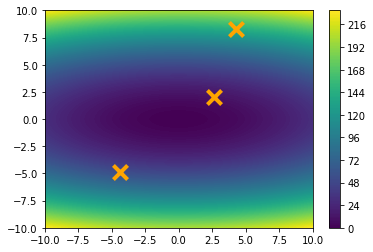

In [6]:
set_random_seed(111)

N_points = 3
X_train = torch.rand(N_points, 2)*20 + torch.FloatTensor([-10, -10])
y_train = target_func(X_train)

plot_obj(target_func)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

# ----

In [7]:
def train(model, num_steps=1000, adam_params={"lr":0.1}):
    """ Trains the semi-parametric model. """
        
    # Autoguide
    guide = autoguide.AutoMultivariateNormal(model.model)

    # Optimizer
    optimizer = pyro.optim.Adam(adam_params)
    loss = Trace_ELBO()
    svi = SVI(model.model, guide, optimizer, loss)
    
    # do gradient steps
    losses = []
    for _ in range(num_steps):
        losses.append(svi.step())
    
    return losses, guide

In [8]:
def find_a_candidate(model_predict, x_init, constr, num_steps=1000, lr=0.1, num_samples=5):
    """ Finds new candidate """
    
    def transf_values(values, constr, dims, inv_mode=False):
        """ Transforming (un)constrained variables to (un)constrained domain """
        
        x_tmp = ()
        for i in range(dims):
            if inv_mode:
                x_tmp += (transform_to(constr[i]).inv(values[:, i]), )
            else:
                x_tmp += (transform_to(constr[i])(values[:, i]), )
            
        x = torch.stack(x_tmp, dim=1)
        return x
            
    x_dims = x_init.shape[-1]
    
    x_uncon_init = transf_values(x_init, constr, x_dims, inv_mode=True)
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # TODO: at the moment we are using torch optimizer, should we change to pyro?
    #     unconstrained minimiser 
    minimizer = optim.Adam([x_uncon], lr=lr)
    
    def closure():
        minimizer.zero_grad()
        x = transf_values(x_uncon, constr, x_dims)
        
        y = model_predict(x)['EI'].mean(0)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))      
        return y
    
    for _ in range(num_steps):
        minimizer.step(closure)
   
    x = transf_values(x_uncon, constr, x_dims)
    
    return x.detach()

In [9]:
def next_x(model_predict, constr, num_candidates=5, num_steps=1000, lr=0.1, num_samples=5):
    """ Finds the next best candidate on the acquisition function surface """
    
    candidates = []
    values = []
    
    # start with the last step
    x_init = model_predict.model.X[-1:]
    for i in range(num_candidates):

        x_can = find_a_candidate(model_predict, x_init, constr, 
                             num_steps=num_steps, lr=lr, num_samples=num_samples)
        
        y = model_predict(x_can)['EI'].mean(0)
        
        candidates.append(x_can)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x_can[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x_can[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
        
    return candidates[argmin]

In [19]:
def update_posterior(model, obj_function, x_new, num_steps=1000, adam_params={"lr":0.1}):
    
    # evaluate f at new point
    bh_y = obj_function(x_new) 
        
    # incorporate new evaluation
    X = torch.cat([model.X, x_new]) 
    y = torch.cat([model.y, bh_y])
    
    model.X = X
    model.y = y
    
    # TODO: Check if this necessary
    model.gp.set_data(X, y)
    
    losses, guide = train(model, num_steps=num_steps, adam_params=adam_params)
    
    return guide, losses

# ----

# GP BayesOpt Parameters

In [11]:
# Adam parameters
adam_num_steps = 1000
adam_params={"lr": 0.1}

# BayesOpt parameters
num_candidates = 5
bo_steps = 20
num_samples = 1

num_tests = 20

In [20]:
pyro.clear_param_store()

# GP kernel
kernel = gp.kernels.Matern52(
    input_dim = X_train.shape[1], 
    lengthscale = 10*torch.ones(X_train.shape[1]))

gp_model = GPRegressionModule(X_train, y_train, kernel)

gp_model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([X_train.shape[1]]).to_event())
gp_model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
gp_model.gp.noise = PyroSample(dist.Uniform(0, 1))

In [21]:
losses, gp_model_guide = train(gp_model, num_steps=adam_num_steps, adam_params=adam_params)

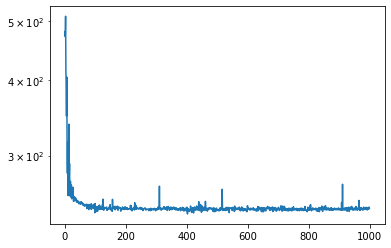

In [22]:
plt.semilogy(losses);

In [23]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
                                             num_samples=num_samples, return_sites=('EI',))

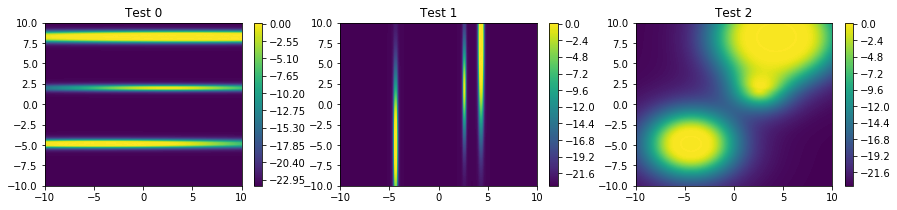

In [24]:
plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 1

In [25]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[-9.9226,  9.9960]])


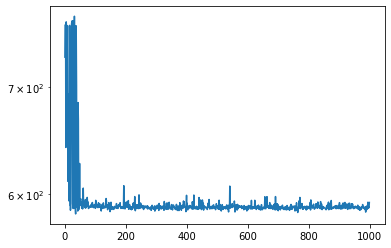

In [26]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

In [27]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

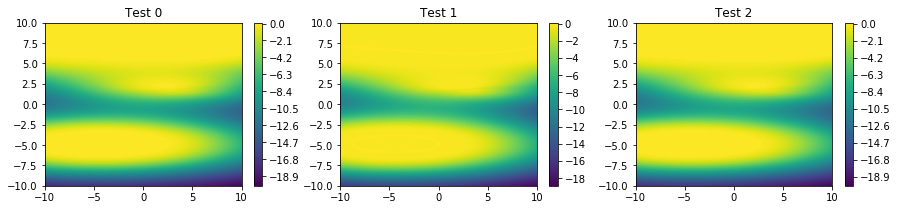

In [28]:
plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 2

In [29]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[-9.9954, -9.9955]])


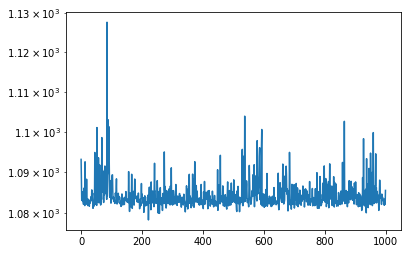

In [30]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

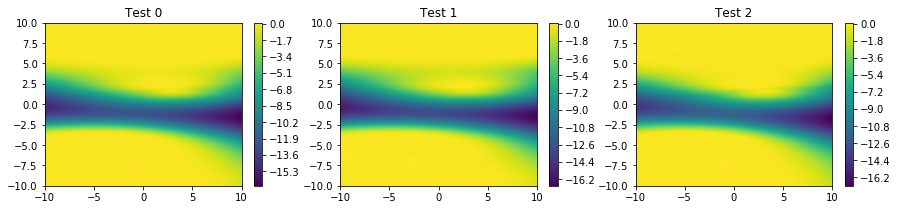

In [31]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 3

In [32]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[ 9.9953, -1.7982]])


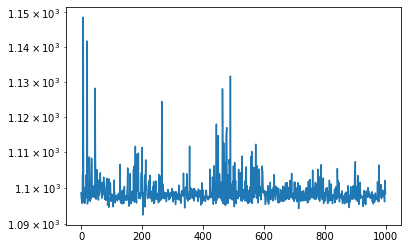

In [33]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

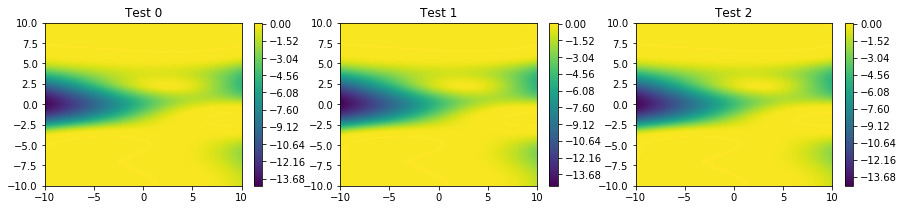

In [34]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 4

In [35]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[-9.9957,  0.1843]])


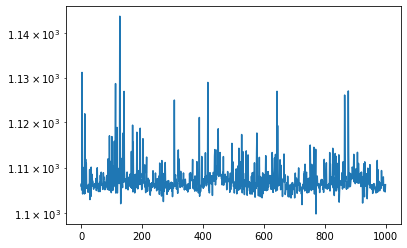

In [36]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

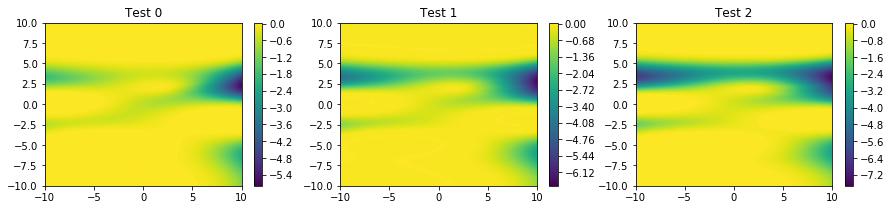

In [37]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 5

In [38]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[-9.9980,  3.3633]])


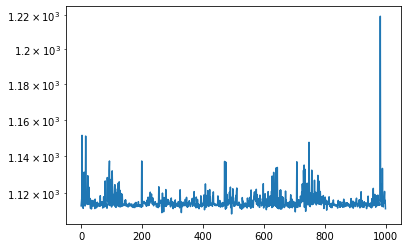

In [39]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

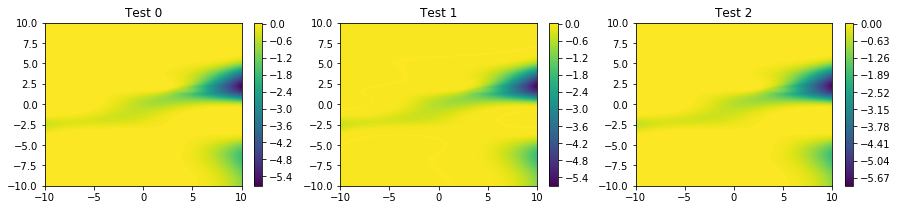

In [40]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 6

In [41]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[9.9971, 2.2163]])


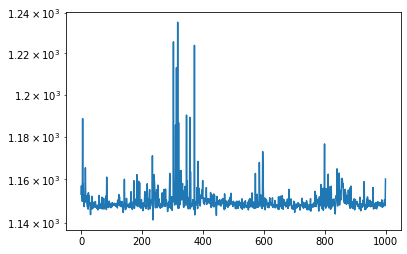

In [42]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

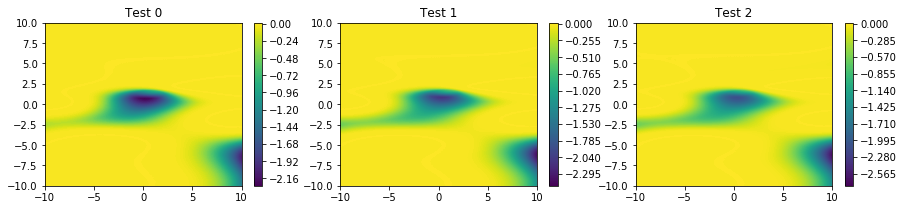

In [43]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))


# Step 7

In [44]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[ 9.9992, -6.4399]])


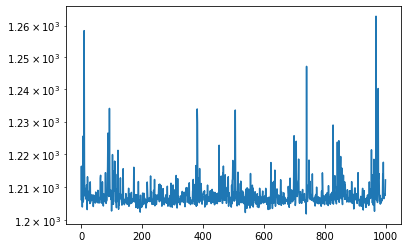

In [45]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

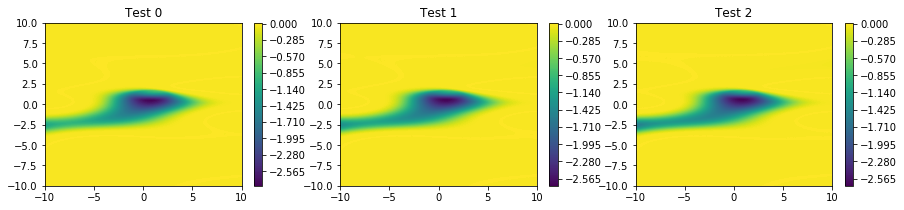

In [46]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 8

In [47]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[0.6763, 0.5266]])


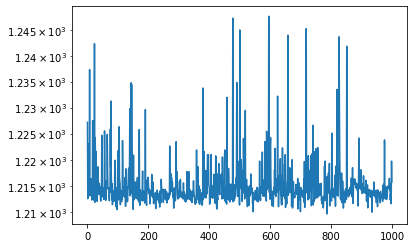

In [48]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

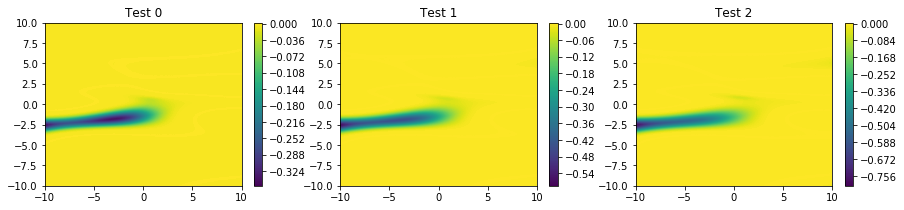

In [49]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 9

In [50]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[-9.9952, -2.6137]])


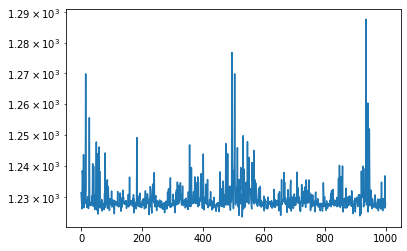

In [51]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

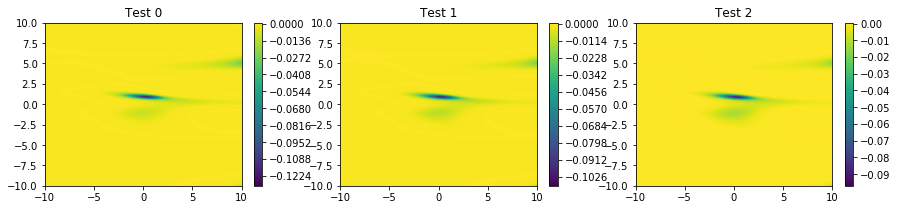

In [52]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

# Step 10

In [53]:
x_new = next_x(gp_model_predict, constr, 
    num_candidates=num_candidates, num_steps=adam_num_steps, num_samples=num_samples)
print(x_new)

tensor([[9.9986, 5.0549]])


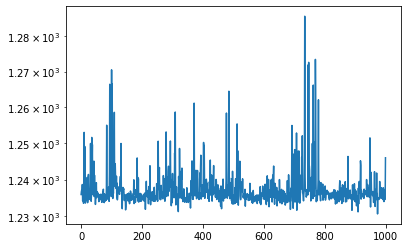

In [54]:
gp_model_guide, losses = update_posterior(gp_model, target_func, x_new, 
    num_steps=adam_num_steps, adam_params=adam_params)
plt.semilogy(losses);

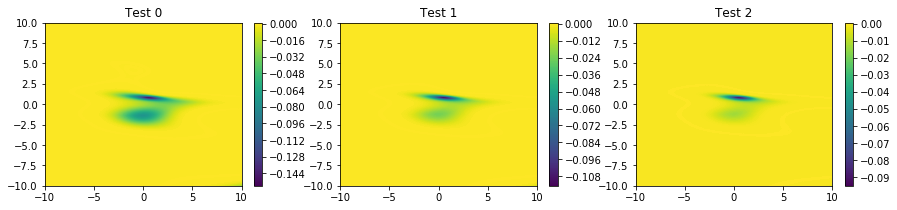

In [55]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI',))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['EI'].mean(0))

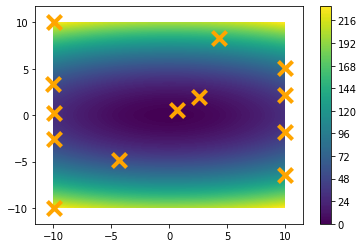

In [58]:
plot_obj(target_func)
plt.scatter(gp_model.X[:,0].detach().numpy(), gp_model.X[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

In [59]:
gp_model.X

tensor([[ 4.3113,  8.2799],
        [-4.3628, -4.8380],
        [ 2.6222,  2.0011],
        [-9.9226,  9.9960],
        [-9.9954, -9.9955],
        [ 9.9953, -1.7982],
        [-9.9957,  0.1843],
        [-9.9980,  3.3633],
        [ 9.9971,  2.2163],
        [ 9.9992, -6.4399],
        [ 0.6763,  0.5266],
        [-9.9952, -2.6137],
        [ 9.9986,  5.0549]])

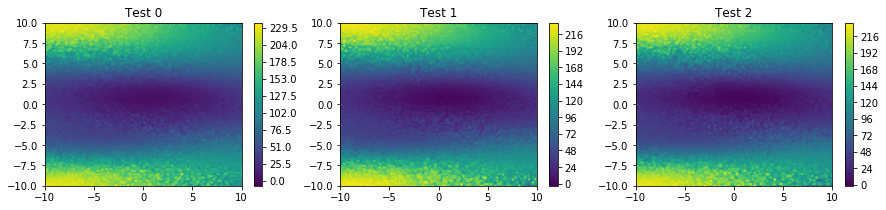

In [63]:
gp_model_predict = pyro.infer.Predictive(gp_model, guide=gp_model_guide, 
    num_samples=num_samples, return_sites=('EI','y'))

plt.figure(figsize=(15, 3)) 
for i in range(3):
    with torch.no_grad():
        plt.subplot(1,3,i+1)
        plt.title("Test %d" % (i))
        plot_obj(lambda X: gp_model_predict(X)['y'].mean(0))